# Example: Train Barlow Twins on CIFAR10
## Anomaly detection by point cloud distance inspecting

In [1]:
!nvidia-smi

Tue Mar 22 23:55:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           Off  | 00000000:3D:00.0 Off |                  Off |
| N/A   29C    P0    37W / 150W |    879MiB /  8129MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl

import lightly
import lightly.data as data

import pytorch_lightning as pl
from torch.utils.data import Subset
from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction

## Variables

In [3]:
BATCH_SIZE = 128
N_EPOCHES = 100
torch.manual_seed(1)
data_path = "../data/cifar10"

# 1. BarlowTwins model

In [4]:
# import our own modules
import sys
sys.path.append("../src")
from my_resnet import resnet20
from utils import get_classes, custom_collate_fn
from barlow_twins_model import BarlowTwins

In [5]:
resnet = resnet20(num_classes=1) #ResNet20
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BarlowTwins(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BarlowTwins(
  (backbone): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size

## Data loader CIFAR10

In [6]:
cifar10_train = torchvision.datasets.CIFAR10(data_path, download=True, train=True)
cifar10_test = torchvision.datasets.CIFAR10(data_path, download=True, train=False)

classes_ids_train = get_classes(cifar10_train) # long!
classes_ids_test = get_classes(cifar10_test)
dataset = LightlyDataset.from_torch_dataset(Subset(cifar10_train, classes_ids_train['dog']))

Files already downloaded and verified
Files already downloaded and verified


## Train Model

In [7]:
from lightly.loss import BarlowTwinsLoss

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    collate_fn=custom_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=2,
)

criterion = BarlowTwinsLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.06)

In [8]:
def interactive_plot(x_range, avg_loss):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Avg loss')#, #color=color)
    ax.plot(x_range, avg_loss, 'r',  ls = '--')
    ax.tick_params(axis='y')#, labelcolor=color)
    ax.grid()
    plt.show()

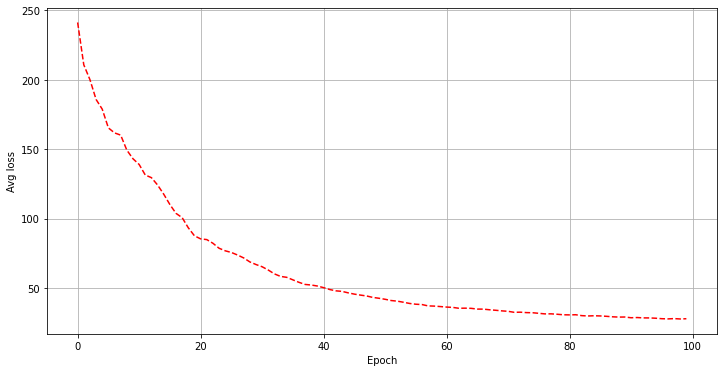

In [9]:
from IPython import display
print("Starting Training")
epochs = range(N_EPOCHES)
avg_losses = []

for epoch in epochs:
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    avg_loss = total_loss / len(dataloader)
    avg_losses.append(avg_loss.cpu().detach())
    print(f"epoch: {epoch: > 2}, loss: {avg_loss:.5f}")
    display.clear_output(wait=True)
    interactive_plot(np.arange(epoch+1), avg_losses)

## Save model weights

In [15]:
torch.save(model.state_dict(), '../weights/weights_barlow_twins')

# 2. Embeddings extraction

In [11]:
cifar10_ = torchvision.datasets.CIFAR10(data_path, download=False, train=False)


classes_ids_test = get_classes(cifar10_)
dataset_trucks = LightlyDataset.from_torch_dataset(Subset(cifar10_, classes_ids_test['truck']))
dataset_dogs = LightlyDataset.from_torch_dataset(Subset(cifar10_, classes_ids_test['dog']))

dataloader_train_dogs = torch.utils.data.DataLoader(
    dataset_dogs,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=True)

dataloader_train_trucks = torch.utils.data.DataLoader(
    dataset_trucks,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=True)

In [12]:
from utils import generate_embeddings

model.eval()

# generate embeddings for trucks/dog
embeddings_dog, filenames_dog = generate_embeddings(model, dataloader_train_dogs, device)
embeddings_trucks, filenames_trucks = generate_embeddings(model, dataloader_train_trucks, device)

# 3. Calculate Hausdorff distance between poin clouds

In [14]:
from scipy.spatial.distance import directed_hausdorff

hausdorff_dist = directed_hausdorff(embeddings_dog, embeddings_trucks)[0]

print(f'Hausdorff Dist: {hausdorff_dist:.3f}')

Hausdorff Dist: 0.445
